In [85]:
import findspark
findspark.init(r"C:\spark") # Spark'ın kurulu olduğu dizin

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [3]:
# Spark Uygulamasını Başlatma

In [4]:
spark = SparkSession.builder.master("local").appName("spark_ilk").getOrCreate()

In [5]:
sc = spark.sparkContext

In [6]:
sc

<SparkContext master=local appName=spark_ilk>

In [7]:
# sc.stop() # spark bağlantısını kapatma

In [8]:
spark_df = spark.read.csv("churn.csv", header=True, inferSchema=True)

In [9]:
spark_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Churn: integer (nullable = true)



In [10]:
spark_df.head(3)

[Row(_c0=0, Names='Cameron Williams', Age=42.0, Total_Purchase=11066.8, Account_Manager=0, Years=7.22, Num_Sites=8.0, Churn=1),
 Row(_c0=1, Names='Kevin Mueller', Age=41.0, Total_Purchase=11916.22, Account_Manager=0, Years=6.5, Num_Sites=11.0, Churn=1),
 Row(_c0=2, Names='Eric Lozano', Age=38.0, Total_Purchase=12884.75, Account_Manager=0, Years=6.67, Num_Sites=12.0, Churn=1)]

In [11]:
spark_df.dtypes

[('_c0', 'int'),
 ('Names', 'string'),
 ('Age', 'double'),
 ('Total_Purchase', 'double'),
 ('Account_Manager', 'int'),
 ('Years', 'double'),
 ('Num_Sites', 'double'),
 ('Churn', 'int')]

In [12]:
spark_df.show(3, truncate=True)

+---+----------------+----+--------------+---------------+-----+---------+-----+
|_c0|           Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|Churn|
+---+----------------+----+--------------+---------------+-----+---------+-----+
|  0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|  1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
|  2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|
+---+----------------+----+--------------+---------------+-----+---------+-----+
only showing top 3 rows



In [13]:
spark_df.count()

900

In [14]:
spark_df.describe("Total_Purchase").show()

+-------+-----------------+
|summary|   Total_Purchase|
+-------+-----------------+
|  count|              900|
|   mean|10062.82403333334|
| stddev|2408.644531858096|
|    min|            100.0|
|    max|         18026.01|
+-------+-----------------+



In [15]:
spark_df.select("Age","Total_Purchase","Years").show(8)

+----+--------------+-----+
| Age|Total_Purchase|Years|
+----+--------------+-----+
|42.0|       11066.8| 7.22|
|41.0|      11916.22|  6.5|
|38.0|      12884.75| 6.67|
|42.0|       8010.76| 6.71|
|37.0|       9191.58| 5.56|
|48.0|      10356.02| 5.12|
|44.0|      11331.58| 5.23|
|32.0|       9885.12| 6.92|
+----+--------------+-----+
only showing top 8 rows



In [16]:
spark_df.filter(spark_df.Years > 5).count()

519

In [17]:
spark_df.groupby("Churn").count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|  150|
|    0|  750|
+-----+-----+



In [18]:
spark_df.groupby("Churn").agg({"Age":"mean", "Years":"mode"}).show()

+-----+-----------+-----------------+
|Churn|mode(Years)|         avg(Age)|
+-----+-----------+-----------------+
|    1|       5.86|42.99333333333333|
|    0|       5.89|41.58133333333333|
+-----+-----------+-----------------+



### SQL İşlemleri 

In [23]:
spark_df.createOrReplaceTempView("tablex")

In [24]:
spark.sql("show databases").show()

+---------+
|namespace|
+---------+
|  default|
+---------+



In [25]:
spark.sql("show tables").show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|         |    table|       true|
|         |   tablex|       true|
+---------+---------+-----------+



In [27]:
spark.sql("Select Age from tablex").show(5)

+----+
| Age|
+----+
|42.0|
|41.0|
|38.0|
|42.0|
|37.0|
+----+
only showing top 5 rows



In [29]:
spark.sql("Select Churn, mean(Age) from tablex group by Churn").show()

+-----+-----------------+
|Churn|        mean(Age)|
+-----+-----------------+
|    1|42.99333333333333|
|    0|41.58133333333333|
+-----+-----------------+



In [32]:
spark.sql("Select * from tablex where Churn = 1 ORDER BY _c0 DESC").show(10)

+---+----------------+----+--------------+---------------+-----+---------+-----+
|_c0|           Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|Churn|
+---+----------------+----+--------------+---------------+-----+---------+-----+
|149|    Yvette Perry|41.0|       8560.76|              1| 3.99|     12.0|    1|
|148|     Tara Burton|49.0|      11177.08|              0| 4.44|     12.0|    1|
|147|    Robert Russo|58.0|       9703.93|              0| 5.16|     11.0|    1|
|146|     Anna Bryant|39.0|       8801.86|              1| 4.43|     10.0|    1|
|145|   Randall Weber|34.0|      12983.26|              1| 6.53|     13.0|    1|
|144|  Hailey Sanchez|41.0|      14429.41|              1| 5.51|     11.0|    1|
|143|Steven Stevenson|52.0|       7460.05|              0| 5.39|     12.0|    1|
|142| Heather Hickman|31.0|      11297.57|              1| 6.23|     10.0|    1|
|141|     Alexis Hill|39.0|       6351.79|              0| 5.86|      6.0|    1|
|140|  Jessica Horton|43.0| 

### Büyük Veri Görselleştirme

In [39]:
sdf = spark_df.toPandas()

In [40]:
sdf.head()

,_c0,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
0,0,Cameron Williams,42.0,11066.80,0,7.22,8.0,1
1,1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,1
2,2,Eric Lozano,38.0,12884.75,0,6.67,12.0,1
3,3,Phillip White,42.0,8010.76,0,6.71,10.0,1
4,4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,1


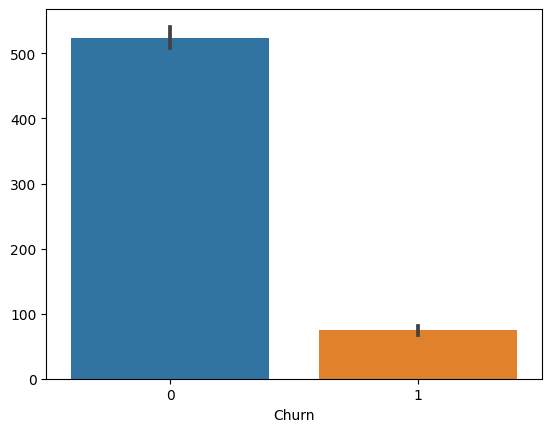

In [41]:
sns.barplot(x="Churn", y=sdf.Churn.index, data=sdf);

### Büyük Veride Makine Öğrenmesi
#### Veri Ön İşleme

In [43]:
spark_df.show(5)

+---+----------------+----+--------------+---------------+-----+---------+-----+
|_c0|           Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|Churn|
+---+----------------+----+--------------+---------------+-----+---------+-----+
|  0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|  1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
|  2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|
|  3|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|    1|
|  4|  Cynthia Norton|37.0|       9191.58|              0| 5.56|      9.0|    1|
+---+----------------+----+--------------+---------------+-----+---------+-----+
only showing top 5 rows



In [47]:
spark_df = spark_df.toDF(*[i.lower() for i in spark_df.columns])

In [48]:
spark_df.show(5)

+---+----------------+----+--------------+---------------+-----+---------+-----+
|_c0|           names| age|total_purchase|account_manager|years|num_sites|churn|
+---+----------------+----+--------------+---------------+-----+---------+-----+
|  0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|  1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
|  2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|
|  3|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|    1|
|  4|  Cynthia Norton|37.0|       9191.58|              0| 5.56|      9.0|    1|
+---+----------------+----+--------------+---------------+-----+---------+-----+
only showing top 5 rows



In [49]:
spark_df = spark_df.withColumnRenamed("_c0", "id")

In [50]:
spark_df.show(5)

+---+----------------+----+--------------+---------------+-----+---------+-----+
| id|           names| age|total_purchase|account_manager|years|num_sites|churn|
+---+----------------+----+--------------+---------------+-----+---------+-----+
|  0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|  1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
|  2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|
|  3|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|    1|
|  4|  Cynthia Norton|37.0|       9191.58|              0| 5.56|      9.0|    1|
+---+----------------+----+--------------+---------------+-----+---------+-----+
only showing top 5 rows



In [56]:
spark_df.select("age","total_purchase","account_manager","years","num_sites","churn").describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,900,41.81666666666667,6.127560416916251,22.0,65.0
total_purchase,900,10062.82403333334,2408.644531858096,100.0,18026.01
account_manager,900,0.4811111111111111,0.4999208935073339,0,1
years,900,5.27315555555555,1.274449013194616,1.0,9.15
num_sites,900,8.587777777777777,1.7648355920350969,3.0,14.0
churn,900,0.16666666666666666,0.3728852122772358,0,1


In [57]:
spark_df = spark_df.dropna()

In [58]:
spark_df = spark_df.withColumn("age_10y_old", spark_df.age+10)

In [59]:
spark_df.show(5)

+---+----------------+----+--------------+---------------+-----+---------+-----+-----------+
| id|           names| age|total_purchase|account_manager|years|num_sites|churn|age_10y_old|
+---+----------------+----+--------------+---------------+-----+---------+-----+-----------+
|  0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|       52.0|
|  1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|       51.0|
|  2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|       48.0|
|  3|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|    1|       52.0|
|  4|  Cynthia Norton|37.0|       9191.58|              0| 5.56|      9.0|    1|       47.0|
+---+----------------+----+--------------+---------------+-----+---------+-----+-----------+
only showing top 5 rows



In [61]:
spark_df = spark_df.withColumn("label", spark_df.churn)

In [62]:
spark_df.show(5)

+---+----------------+----+--------------+---------------+-----+---------+-----+-----------+-----+
| id|           names| age|total_purchase|account_manager|years|num_sites|churn|age_10y_old|label|
+---+----------------+----+--------------+---------------+-----+---------+-----+-----------+-----+
|  0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|       52.0|    1|
|  1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|       51.0|    1|
|  2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|       48.0|    1|
|  3|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|    1|       52.0|    1|
|  4|  Cynthia Norton|37.0|       9191.58|              0| 5.56|      9.0|    1|       47.0|    1|
+---+----------------+----+--------------+---------------+-----+---------+-----+-----------+-----+
only showing top 5 rows



In [63]:
spark_df.dtypes

[('id', 'int'),
 ('names', 'string'),
 ('age', 'double'),
 ('total_purchase', 'double'),
 ('account_manager', 'int'),
 ('years', 'double'),
 ('num_sites', 'double'),
 ('churn', 'int'),
 ('age_10y_old', 'double'),
 ('label', 'int')]

In [65]:
degiskenler = ["age","total_purchase","account_manager","years","num_sites"]

In [67]:
vectorAssembler = VectorAssembler(inputCols=degiskenler, outputCol="features")
va_df = vectorAssembler.transform(spark_df)

In [69]:
va_df.show(4)

+---+----------------+----+--------------+---------------+-----+---------+-----+-----------+-----+--------------------+
| id|           names| age|total_purchase|account_manager|years|num_sites|churn|age_10y_old|label|            features|
+---+----------------+----+--------------+---------------+-----+---------+-----+-----------+-----+--------------------+
|  0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|       52.0|    1|[42.0,11066.8,0.0...|
|  1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|       51.0|    1|[41.0,11916.22,0....|
|  2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|       48.0|    1|[38.0,12884.75,0....|
|  3|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|    1|       52.0|    1|[42.0,8010.76,0.0...|
+---+----------------+----+--------------+---------------+-----+---------+-----+-----------+-----+--------------------+
only showing top 4 rows



In [70]:
final_df = va_df.select(["features", "label"])

In [72]:
final_df.show(3)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[42.0,11066.8,0.0...|    1|
|[41.0,11916.22,0....|    1|
|[38.0,12884.75,0....|    1|
+--------------------+-----+
only showing top 3 rows



In [74]:
# train-test ayrımı

In [75]:
splits = final_df.randomSplit([.7, .3])

In [78]:
splits

[DataFrame[features: vector, label: int],
 DataFrame[features: vector, label: int]]

In [79]:
train_df = splits[0]
test_df = splits[1]

#### GBM ile Müşteri Kaybı Sınıflandırma Modeli

In [86]:
gbm = GBTClassifier(maxIter=10, featuresCol="features", labelCol="label")
gbm_model = gbm.fit(train_df)

In [87]:
sc

<SparkContext master=local appName=spark_ilk>

In [88]:
y_pred = gbm_model.transform(test_df)

In [89]:
y_pred

DataFrame[features: vector, label: int, rawPrediction: vector, probability: vector, prediction: double]

In [90]:
ac = y_pred.select("label","prediction")

In [93]:
ac.filter(ac.label == ac.prediction).count() / ac.count() # Test doğruluğu %

0.8297872340425532

In [94]:
# Model Tuning

In [97]:
gbm = GBTClassifier(featuresCol="features", labelCol="label")

evaluator = BinaryClassificationEvaluator()

params = (ParamGridBuilder()
          .addGrid(gbm.maxDepth, [2, 4, 6])
          .addGrid(gbm.maxBins, [20, 30])
          .addGrid(gbm.maxIter, [10, 20])
          .build())

cv = CrossValidator(estimator=gbm, estimatorParamMaps=params, evaluator=evaluator, numFolds=10)


In [98]:
cvModel = cv.fit(train_df)

In [99]:
y_pred = cvModel.transform(test_df)

In [100]:
ac = y_pred.select("label","prediction")

In [101]:
ac.filter(ac.label == ac.prediction).count() / ac.count() # Test doğruluğu %

0.8723404255319149

In [121]:
# Modeli yeni müşteriler üzerinden test edelim

In [138]:
df = pd.read_csv("churn.csv", index_col=0)
df.head()

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,1
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,1
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,1
3,Phillip White,42.0,8010.76,0,6.71,10.0,1
4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,1


In [139]:
musteriler = df.iloc[3:500:67,:] # verisetinden birkaç müşteri örneği alıyoruz

In [140]:
musteriler.columns = [i.lower() for i in musteriler.columns]

In [141]:
musteriler = musteriler.drop("churn", axis=1)

In [142]:
yeni_sdf = spark.createDataFrame(musteriler)
yeni_sdf.show()

+----------------+----+--------------+---------------+-----+---------+
|           names| age|total_purchase|account_manager|years|num_sites|
+----------------+----+--------------+---------------+-----+---------+
|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|
|    Amber Spears|41.0|      13365.66|              1| 8.36|      9.0|
|   Jacob Escobar|50.0|      14398.89|              1| 5.54|     12.0|
| Lawrence Morton|48.0|       9706.88|              0| 6.45|      8.0|
|     Megan Flynn|48.0|      13298.38|              0| 2.99|      8.0|
|    Tammy Kelley|38.0|       6638.87|              1| 5.61|      8.0|
|     James Evans|42.0|       4492.44|              1| 6.43|      9.0|
|Kathryn Petersen|40.0|      12453.72|              1| 4.83|      9.0|
+----------------+----+--------------+---------------+-----+---------+



In [130]:
musteriler = vectorAssembler.transform(yeni_sdf)

In [131]:
sonuclar = cvModel.transform(musteriler)

In [143]:
sonuclar.select("names","prediction").show()

+----------------+----------+
|           names|prediction|
+----------------+----------+
|   Phillip White|       0.0|
|    Amber Spears|       0.0|
|   Jacob Escobar|       1.0|
| Lawrence Morton|       0.0|
|     Megan Flynn|       0.0|
|    Tammy Kelley|       0.0|
|     James Evans|       0.0|
|Kathryn Petersen|       0.0|
+----------------+----------+

